### Load Test deployed web application
This notebook pulls some images and tests them against the deployed web application. We submit requests asychronously which should reduce the contribution of latency.

In [1]:
import urllib.request
import matplotlib.pyplot as plt
import aiohttp
import asyncio
import requests
import json
import random
import numpy as np
import testing_utilities
import time
from io import BytesIO
from PIL import Image, ImageOps
%matplotlib inline

In [2]:
print(aiohttp.__version__)  # 2.0.3

2.0.3


In [3]:
# SET
NUM = 100  # Total number of requests
CONC = 50  # Number of requests at a time

In [4]:
app_url = 'ikcntkacsagents.southcentralus.cloudapp.azure.com'
app_id = '/cntkresnet'

In [5]:
scoring_url = 'http://{}/score'.format(app_url)
version_url = 'http://{}/version'.format(app_url)

In [6]:
!curl $version_url # Reports the CNTK Version

2.0rc1

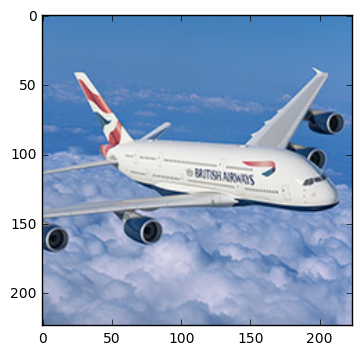

In [7]:
IMAGEURL = "https://www.britishairways.com/assets/images/information/about-ba/fleet-facts/airbus-380-800/photo-gallery/240x295-BA-A380-exterior-2-high-res.jpg"
plt.imshow(testing_utilities.to_img(IMAGEURL))

In [8]:
def gen_variations_of_one_image(num):
    out_images = []
    img = testing_utilities.to_img(IMAGEURL).convert('RGB')
    # Flip the colours for one-pixel
    # "Different Image"
    for i in range(num):
        diff_img = img.copy()
        rndm_pixel_x_y = (random.randint(0, diff_img.size[0]-1), 
                          random.randint(0, diff_img.size[1]-1))
        current_color = diff_img.getpixel(rndm_pixel_x_y)
        diff_img.putpixel(rndm_pixel_x_y, current_color[::-1])
        b64img = testing_utilities.to_base64(diff_img)
        out_images.append(json.dumps({'input':'[\"{0}\"]'.format(b64img)}))
    return out_images

In [9]:
url_list = [[scoring_url, jsonimg] for jsonimg in gen_variations_of_one_image(NUM)]

In [10]:
headers = {'content-type': 'application/json','X-Marathon-App-Id': app_id}

In [11]:
def handle_req(data):
    return json.loads(data.decode('utf-8'))['result'][0][0][0][0]

In [12]:
def chunked_http_client(num_chunks, s):
    # Use semaphore to limit number of requests
    semaphore = asyncio.Semaphore(num_chunks)
    @asyncio.coroutine
    def http_get(dta):
        nonlocal semaphore
        with (yield from semaphore):
            url, jsonimg = dta
            response = yield from s.request('post', url, data=jsonimg, headers=headers)
            body = yield from response.content.read()
            yield from response.wait_for_close()
        return body
    return http_get

In [13]:
def run_experiment(urls):
    with aiohttp.ClientSession() as session:
        http_client = chunked_http_client(num_chunks=CONC, s=session)
        # http_client returns futures, save all the futures to a list
        tasks = [http_client(url) for url in urls]
        responses = []
        # wait for futures to be ready then iterate over them
        for future in asyncio.as_completed(tasks):
            data = yield from future
            try:
                out = handle_req(data)
                responses.append(out)
            except Exception as err:
                print("Error {0}".format(err))
        return responses

In [14]:
loop = asyncio.get_event_loop()

In [15]:
stime = time.time()
complete_responses = loop.run_until_complete(run_experiment(url_list))
timer_results = time.time() - stime

In [16]:
# Successful responses
complete_responses.count(complete_responses[0])

100

In [17]:
print('Average time taken: {0:4.2f} ms'.format(10**3 * timer_results/len(complete_responses)))

Average time taken: 807.00 ms


'n02690373 airliner'

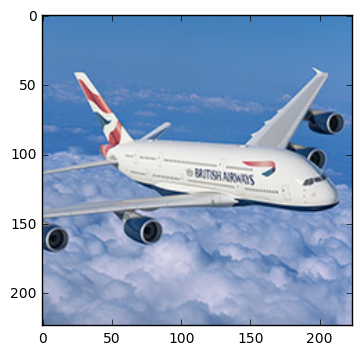

In [19]:
# Example response
plt.imshow(testing_utilities.to_img(IMAGEURL))
complete_responses[0]